In [1]:
import tensorflow
import numpy as np
print(tensorflow.__version__)

2.5.0


In [2]:
from tensorflow.keras.datasets import imdb

In [3]:
(tr_data, tr_cls), (te_data, te_cls) = imdb.load_data(num_words = 10000)

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

#### num_words는 사용할 vocab의 숫자이다. 크게 설정할 수록 적게 등장한 단어까지 사용한다.

In [4]:
tr_data.shape, te_data.shape

((25000,), (25000,))

#### 학습 데이터가 25,000개 테스트 데이터가 25,000개가 있다.

In [5]:
tr_data[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

#### 실제 텍스트 데이터는 토큰화를 통해서 인코딩을 해야하지만 이미 되어있는 것을 알 수 있다.

In [6]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [7]:
train = pad_sequences(tr_data, padding = 'post', maxlen = 256)

In [8]:
test = pad_sequences(te_data, padding = 'post', maxlen = 256)

#### pad_sequence로 정수 텐서를 만들어 임베딩층에 사용한다.

In [40]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import GlobalMaxPooling1D, Dense, Embedding, Conv1D, LSTM, GRU, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [10]:
vocab_size = 10000

In [34]:
model = Sequential()
model.add(Embedding(vocab_size, 32, input_shape = (None, )))
model.add(Conv1D(32, 3, padding = 'same', activation = 'swish'))
model.add(Dropout(.3))
model.add(GlobalMaxPooling1D())
model.add(Dense(8, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

#### 공식 홈페이지에는 AveragePooling만 하고 Dense층으로 보내는데 우선 Conv1D를 사용해봄.

In [35]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 32)          3104      
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 32)          0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 323,377
Trainable params: 323,377
Non-trainable params: 0
________________________________________________

In [36]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

In [37]:
es = EarlyStopping(monitor = 'val_acc', patience = 5, mode = 'max', verbose = 1)
mc = ModelCheckpoint('tf_core.h5', monitor = 'val_acc', patience = 5, save_best_only = True, mode = 'max', verbose = 1)

In [38]:
history = model.fit(train, tr_cls, batch_size = 256, epochs = 50, validation_split = .2, callbacks = [es, mc])

Epoch 1/50
79/79 [==============================] - 3s 29ms/step - loss: 0.6779 - acc: 0.6644 - val_loss: 0.6408 - val_acc: 0.7798

Epoch 00001: val_acc improved from -inf to 0.77980, saving model to tf_core.h5
Epoch 2/50
79/79 [==============================] - 2s 25ms/step - loss: 0.4966 - acc: 0.8021 - val_loss: 0.4113 - val_acc: 0.8316

Epoch 00002: val_acc improved from 0.77980 to 0.83160, saving model to tf_core.h5
Epoch 3/50
79/79 [==============================] - 2s 26ms/step - loss: 0.3278 - acc: 0.8600 - val_loss: 0.3386 - val_acc: 0.8600

Epoch 00003: val_acc improved from 0.83160 to 0.86000, saving model to tf_core.h5
Epoch 4/50
79/79 [==============================] - 2s 26ms/step - loss: 0.2520 - acc: 0.8982 - val_loss: 0.3049 - val_acc: 0.8748

Epoch 00004: val_acc improved from 0.86000 to 0.87480, saving model to tf_core.h5
Epoch 5/50
79/79 [==============================] - 2s 26ms/step - loss: 0.1978 - acc: 0.9238 - val_loss: 0.2913 - val_acc: 0.8782

Epoch 00005: va

In [41]:
use_model = load_model('tf_core.h5')

#### 가장 성능이 좋았던 모델을 load한다.

In [44]:
pred = use_model.predict(test)

In [45]:
cls = [1 if p >= .5 else 0 for p in pred]

In [47]:
from sklearn.metrics import accuracy_score

In [49]:
acc = accuracy_score(te_cls, cls)

In [50]:
acc

0.86988

#### test데이터에 대해 약 87%의 정확도를 가지는 것을 알 수 있다.

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline

In [53]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [54]:
epochs = range(1, len(acc) + 1)

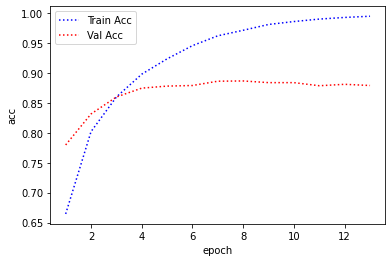

In [56]:
plt.plot(epochs, acc, linestyle = ':', color = 'b', label = 'Train Acc')
plt.plot(epochs, val_acc, linestyle = ':', color = 'r', label = 'Val Acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

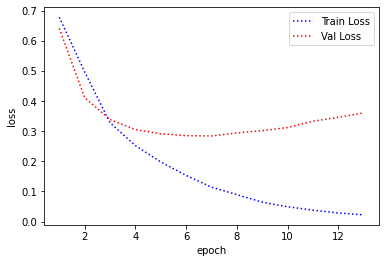

In [58]:
plt.plot(epochs, loss, linestyle = ':', color = 'b', label = 'Train Loss')
plt.plot(epochs, val_loss, linestyle = ':', color = 'r', label = 'Val Loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()